In [326]:
import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist

# for CI testing
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.6')
pyro.set_rng_seed(1)


# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

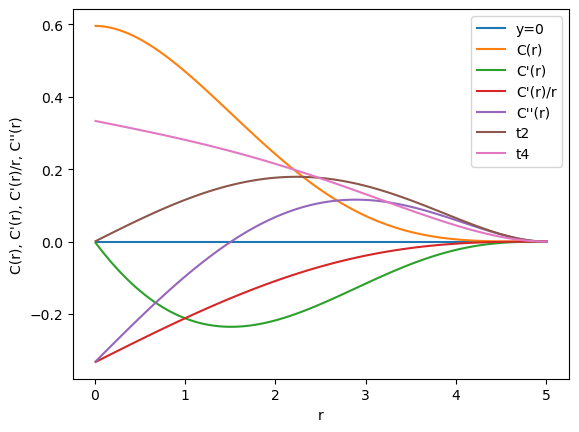

In [327]:
a_T = 5
c_o_T = a_T**2/14/3
c_o_T
def covariance_function(r):
    r_by_at = r/a_T
    C_r = c_o_T *( 1 - 7 * (r_by_at)**2 + 8.75 * (r_by_at)**3 - 3.5 * (r_by_at)**5 + 0.75 * (r_by_at)**7)
    return C_r
def first_derivative_covariance_function(r):
    C_r_dash =c_o_T *( - 14 * (r/a_T**2) + 105/4 * (r**2/a_T**3) - 35/2 * (r**4/a_T**5) + 21/4 * (r**6/a_T**7))
    # C_r_dash =c_o_T *( - 14 * (r_by_at)**2 + 105/4 * (r_by_at)**3 - 35/2 * (r_by_at)**5 + 21/4 * (r_by_at)**7)/ r
    #print("C_r_dash\n", C_r_dash)
    return C_r_dash
def first_derivative_covariance_function_divided_by_r(r):
    C_r_dash_by_r = c_o_T *( - 14 / ((a_T)**2) + 105/4 * (r/(a_T)**3) - 35/2 * (r**3/(a_T)**5) + 21/4 * (r**5/(a_T)**7))
    return C_r_dash_by_r
def second_derivative_covariance_function(r):
    C_r_dash_dash =c_o_T * 7 * (9 * r ** 5 - 20 * a_T ** 2 * r ** 3 + 15 * a_T ** 4 * r - 4 * a_T ** 5) / (2 * a_T ** 7)
    return C_r_dash_dash
# plot the function
r =torch.linspace(0.01,a_T, 100)
C_r = covariance_function(r)
C_r_dash = first_derivative_covariance_function(r)
C_r_dash_by_r = first_derivative_covariance_function_divided_by_r(r)
C_r_dash_dash = second_derivative_covariance_function(r)
t2 = - first_derivative_covariance_function_divided_by_r(r) + second_derivative_covariance_function(r)
t4 = 0.6 * t2 -C_r_dash_by_r
plt.plot(r,torch.zeros(len(r)))
plt.plot(r,C_r)
plt.plot(r,C_r_dash)
plt.plot(r,C_r_dash_by_r)
plt.plot(r, C_r_dash_dash)
plt.plot(r, t2)
plt.plot(r, t4)
plt.xlabel("r")
plt.ylabel("C(r), C'(r), C'(r)/r, C''(r)")
plt.legend(["y=0","C(r)", "C'(r)","C'(r)/r", "C''(r)","t2", "t4"])
plt.show()

In [328]:
def squared_euclidean_distance(x_1,x_2, Transformation_matrix=torch.eye(2)):
    x_1 = x_1 @ Transformation_matrix.T
    x_2 = x_2 @ Transformation_matrix.T

    sqd = torch.sqrt(torch.clip(torch.reshape(torch.sum(x_1**2,1),shape =(x_1.shape[0],1))+\
    torch.reshape(torch.sum(x_2**2,1),shape =(1,x_2.shape[0]))-\
    2*( x_1@ x_2.T), min=0.0)+ 1e-12)
    
    return sqd

In [329]:
def cartesian_dist_hu(x1, x2, Transformation_matrix=torch.eye(2) ):
    x1 = x1@ Transformation_matrix.T
    x2 = x2@ Transformation_matrix.T
    k = x1.shape[1]
    H =[]
    dummy_H = []
    # We converted x' = x A . 
    # There for delta x' = h_u (old) = delta x A
    for i in range(k):
        delta_x_i = x1[:,i] - torch.reshape(x2[:,i], shape=(x2.shape[0],1))
        H.append(delta_x_i)
    for i in range(k):
        a=torch.zeros(H[i].shape)
        for j in range(k):
            a= a +  Transformation_matrix[j,i] * H[j]
        dummy_H.append(a)
    H = dummy_H
    return H

In [330]:
def cov_gradients(dist_tiled, H, Transformation_matrix=torch.eye(2), nugget_effect_grad=1/3):
    k = len(H) # component of gradient available
    n = int(H[0].shape[0]/ k) # number of place where gradient is defined

    #################################################################################################
    # For cross term of gradient 
    #################################################################################################
    # if we have many component of Gradient, we can club it to make , H =[h_u, h_v, h_w,....] 
    #H =[h_u, h_v] 
    C_G = torch.zeros((n*k, n*k))
    for i in range(len(H)):
        for j in range(len(H)):
            hu_hv = H[i][n*i:n*(i+1), n*j:n*(j+1)] * H[j][n*i:n*(i+1), n*j:n*(j+1)]
            dist =dist_tiled[n*i:n*(i+1), n*j:n*(j+1)]
            dist_sqr = dist **2 
            condition = dist_sqr!=0
            hu_hv_by_dist_sqr = torch.where(condition, hu_hv/ dist_sqr, 0.0)
            
            # Cross gradient term for C_ZuZv
            if i != j:
                t2 = - first_derivative_covariance_function_divided_by_r(dist) + second_derivative_covariance_function(dist)
                anisotrop_term = first_derivative_covariance_function_divided_by_r(dist) * torch.sum(Transformation_matrix[:,i]*Transformation_matrix[:,j])
                array_test = -(hu_hv_by_dist_sqr * t2 + anisotrop_term)
                for l in range(n):
                    for m in range(n):
                        #C_G = C_G.at[i*n+l,j*n+m].set(array_test[l,m])
                        C_G[i*n+l,j*n+m] = array_test[l,m]
                        #C_G = torch.tensor_scatter_nd_update(C_G, indices=[[i*n+l,j*n+m]], updates=[array_test[l,m]])
            # Gradient for similar type of gradient
            else:
                dist_cube = dist **3
                condition = dist_cube!=0
                hu_hv_by_dist_cube = torch.where(condition, hu_hv/dist_cube, 0.0)
                
                t4 = first_derivative_covariance_function(dist)
                
                # Here we have added the last term for anisotropy effect
                t5 = torch.sum((Transformation_matrix[:,i])**2) * first_derivative_covariance_function_divided_by_r(dist) 
                
                t6 = second_derivative_covariance_function(dist)
                
                ################################# Note ############################################
                # Covariance of gradient is negative for points closer to zero
                ##################################################################################
        
                array_test = -(- t4 * hu_hv_by_dist_cube + t5 +  t6 * hu_hv_by_dist_sqr )
                for l in range(n):
                    for m in range(n):
                        C_G[i*n+l,j*n+m] = array_test[l,m]
                        #C_G = C_G.at[i*n+l,j*n+m].set(array_test[l,m])
                        #C_G = torch.tensor_scatter_nd_update(C_G, indices=[[i*n+l,j*n+m]], updates=[array_test[l,m]])
    # If the distance is greater than a, then function C_z(r) = 0 . 
    # Therefore, we can replace the element of covariance matrix with 0 for distance greater than a
    condition_1 = dist_tiled<=a_T
    
    C_G = torch.where(condition_1, C_G, 0.0)
    C_G = C_G + nugget_effect_grad * torch.eye(n*k)

    return C_G

In [331]:
def cov_interface(ref_layer_points,rest_layer_points, Transformation_matrix=torch.eye(2),nugget_effect_interface=1/3):
    sed_rest_rest = squared_euclidean_distance(rest_layer_points,rest_layer_points, Transformation_matrix=Transformation_matrix)
    sed_ref_rest = squared_euclidean_distance(ref_layer_points,rest_layer_points, Transformation_matrix=Transformation_matrix)
    sed_rest_ref = squared_euclidean_distance(rest_layer_points,ref_layer_points, Transformation_matrix=Transformation_matrix)
    sed_ref_ref = squared_euclidean_distance(ref_layer_points,ref_layer_points, Transformation_matrix=Transformation_matrix)
    
    C_I = covariance_function(sed_rest_rest) -\
          covariance_function(sed_ref_rest) -\
          covariance_function(sed_rest_ref) +\
          covariance_function(sed_ref_ref)

    return C_I + nugget_effect_interface * torch.eye(C_I.shape[0])

In [332]:
## Cartesian distance between dips and interface points

def cartesian_dist_no_tile(x_1,x_2, Transformation_matrix=torch.eye(2)):
    x_1 = x_1 @ Transformation_matrix.T
    x_2 = x_2 @ Transformation_matrix.T
    k = x_1[0].shape[0]
    H_I = []
    for i in range(k):
        H_I.append(((x_1[:,i] - torch.reshape(x_2[:,i],[x_2.shape[0],1]))).T)
    
    Dummy_H_I=[]
    
    for i in range(k):
        a=torch.zeros(H_I[i].shape)
        for j in range(k):
            a= a + Transformation_matrix[j,i] * H_I[j]
        Dummy_H_I.append(a)
    
    H_I = Dummy_H_I
    H_I = torch.concat(H_I,axis=0)
    
    return H_I


In [333]:
def cov_interface_gradients(hu_rest,hu_ref, Position_G_Modified, rest_layer_points, ref_layer_points, Transformation_matrix=torch.eye(2)):
    sed_dips_rest = squared_euclidean_distance(Position_G_Modified,rest_layer_points,Transformation_matrix=Transformation_matrix)
    sed_dips_ref = squared_euclidean_distance(Position_G_Modified,ref_layer_points,Transformation_matrix=Transformation_matrix)
    
    C_GI = - hu_rest * first_derivative_covariance_function_divided_by_r(sed_dips_rest) + hu_ref* first_derivative_covariance_function_divided_by_r(sed_dips_ref)
    
    return C_GI

In [334]:
def set_rest_ref_matrix2(number_of_points_per_surface,input_position):
    ref_layer_points=[]
    rest_layer_points=[]
    for layer in input_position:
        ref_layer_points.append(layer[-1])
        rest_layer_points.append(layer[0:-1])
    # refrence points for each layer is repeated as number of non-referenced point
    
    repeats = number_of_points_per_surface-1

    ref_layer_points = torch.repeat_interleave(torch.stack(ref_layer_points ,axis = 0),repeats=repeats,axis = 0) 
    
    # Non referenced point. 
    rest_layer_points = torch.concat(rest_layer_points,axis = 0)
    return ref_layer_points,rest_layer_points

In [335]:
def Ge_model(input_position, gradient_postion, gradient_value,Transformation_matrix=torch.eye(2), nugget_effect_grad=1/3,nugget_effect_interface=1/3,
             plot_fig=False, plot_input_data=False, plot_scalar_field= False):
    ''' 
        Args:
            Input data:
                input_position:     A list of list. Where each element of outer list is the information for each layer. 
                                    Inside each layer is the coordinates of position with last element is the refrence of that layer.
                gradient_position:  A list of coordinates of gradient position
                gradient_value:     Values of Gradient corresponding to the position mentioned in gradient_position
    '''
    # Assuming the there exist different layers in geological model. It can be assumed as scalar field. 
    number_of_layer = len(input_position)
    # Each layer containst the information of location of point where we have the information about scalar data. 
    # The last location is of the reference point for each layer.
    
    ## defining the dips position
    Position_G = gradient_postion # Location where Dips or gradient are given
    Value_G    = gradient_value # Gx, Gy, ..., Gk are the componet of gradient available at the given location
    n= Position_G.shape[0] # Total number of points available for gradient or dips
    k = Position_G[0].shape[0] # Total number of component available for the gradient
    # Since we have two component of the gradient, we can write the position twice corresponding to each coponent. We are assuming that 
    # Z is a scalar not a vector. Therefor we divide gradient into two different Z_u and Z_v
    Position_Add=[]
    
    for i in range(k):
        Position_Add.append(Position_G)
    Position_G_Modified = torch.concat(Position_Add, axis=0)
    
    number_of_points_per_surface=[]
    for i in range(number_of_layer):
        number_of_points_per_surface.append(input_position[i].shape[0])
    number_of_points_per_surface = torch.tensor(number_of_points_per_surface)

    ref_layer_points,rest_layer_points = set_rest_ref_matrix2(number_of_points_per_surface,input_position)

    dist_position = squared_euclidean_distance(Position_G_Modified, Position_G_Modified, Transformation_matrix=Transformation_matrix) 
    # the dist_position can be all zero if there is only one point is defined where gradient is known.
    # 
    dist_position = dist_position #+  torch.eye(dist_position.shape[0])
    #print("dist_position\n",dist_position)
    # Calculate the cartesian distance 
    # Calculate the list H = [hu, hv, ..., hk]
    H = cartesian_dist_hu(Position_G_Modified, Position_G_Modified, Transformation_matrix=Transformation_matrix)
    
    C_G = cov_gradients(dist_tiled=dist_position, H=H, Transformation_matrix=Transformation_matrix,nugget_effect_grad=nugget_effect_grad)
    
    C_I = cov_interface(ref_layer_points,rest_layer_points, Transformation_matrix=Transformation_matrix, nugget_effect_interface=nugget_effect_interface)
    
    hu_rest = cartesian_dist_no_tile(Position_G,rest_layer_points, Transformation_matrix=Transformation_matrix)
    hu_ref = cartesian_dist_no_tile(Position_G,ref_layer_points, Transformation_matrix=Transformation_matrix)   

    C_GI = cov_interface_gradients(hu_rest,hu_ref, Position_G_Modified, rest_layer_points, ref_layer_points, Transformation_matrix=Transformation_matrix)
    #print("C_GI\n", C_GI)
    C_IG = C_GI.T

    K = torch.concat([torch.concat([C_G,C_GI],axis = 1),
    torch.concat([C_IG,C_I],axis = 1)],axis = 0)  

    # For kriging system in dual form require the list of all the Z. For gradient part, we can write the term but for Z(x)-Z(x0)=0 always.
    #Modified_Value_G = Value_G @ Transformation_matrix
    Modified_Value_G = Value_G #@ torch.eye(2)
    Modified_Value_G_flatten = torch.reshape((Modified_Value_G).T, [-1])
    b = torch.concat([Modified_Value_G_flatten,torch.zeros(K.shape[0]-Modified_Value_G_flatten.shape[0])],axis = 0)
    
    b = torch.reshape(b,shape = [b.shape[0],1])
    
    #print(b)
    # For Simple Co-kriging Z_i = m_i  + \Sum w_l(Z_l - m_l)
    # The Equation becomes C W = b and C =K (here)
    #print("K\n", K)
    w = torch.linalg.solve(K,b)
    
    ### check exact interpolator ########
    
    Given_Position_data = torch.tensor([[0.0000,1.0000]])
    #print("Given_Position \n ", Given_Position_data)
    hu_Simpoints_check = cartesian_dist_no_tile(Position_G,Given_Position_data,Transformation_matrix=Transformation_matrix)
    sed_dips_SimPoint_check = squared_euclidean_distance(Position_G_Modified,Given_Position_data, Transformation_matrix=Transformation_matrix)
    sigma_0_grad_check  =  w[:Position_G.shape[0] *2] * (hu_Simpoints_check * first_derivative_covariance_function_divided_by_r(sed_dips_SimPoint_check))
    sigma_0_grad_check = torch.sum(sigma_0_grad_check,axis=0)
    sed_rest_SimPoint_check = squared_euclidean_distance(rest_layer_points,Given_Position_data,Transformation_matrix=Transformation_matrix)
    sed_ref_SimPoint_check = squared_euclidean_distance(ref_layer_points,Given_Position_data, Transformation_matrix=Transformation_matrix)
    sigma_0_interf_check =  w[Position_G.shape[0]*2:]*(-covariance_function(sed_rest_SimPoint_check) + covariance_function(sed_ref_SimPoint_check))
    sigma_0_interf_check = torch.sum(sigma_0_interf_check,axis = 0)
    interpolate_result_check = sigma_0_grad_check+sigma_0_interf_check
    
    ################################################################################
    ## create grid
    xx = torch.arange(-.5,4.5,0.05)
    xx_shape = xx.shape[0]
    zz = torch.arange(-.5,4.5,0.05)
    zz_shape = zz.shape[0]
    XX,ZZ = torch.meshgrid(xx,zz)
    X = (torch.reshape(XX,[-1])).T
    Z = (torch.reshape(ZZ,[-1])).T

    grid = torch.stack([X,Z],axis = 1)
    ref_points = torch.unique(ref_layer_points,dim=0)
    
    grid= torch.concat([grid, ref_points],dim=0)
    
    hu_Simpoints = cartesian_dist_no_tile(Position_G,grid,Transformation_matrix=Transformation_matrix)
    
    sed_dips_SimPoint = squared_euclidean_distance(Position_G_Modified,grid, Transformation_matrix=Transformation_matrix)
    

    ####################################### TODO #######################################
    # Check whether we need to transform first_derivative_covariance_function_divided_by_r 
    # by transformation matrix somehow
    ####################################################################################
    sigma_0_grad  =  w[:Position_G.shape[0] *Position_G.shape[1]] * (hu_Simpoints * first_derivative_covariance_function_divided_by_r(sed_dips_SimPoint))
    
    sigma_0_grad = torch.sum(sigma_0_grad,axis=0)
    

    sed_rest_SimPoint = squared_euclidean_distance(rest_layer_points,grid,Transformation_matrix=Transformation_matrix)
    sed_ref_SimPoint = squared_euclidean_distance(ref_layer_points,grid, Transformation_matrix=Transformation_matrix)

    
    sigma_0_interf =  w[Position_G.shape[0]*Position_G.shape[1]:]*(-covariance_function(sed_rest_SimPoint) + covariance_function(sed_ref_SimPoint))
    sigma_0_interf = torch.sum(sigma_0_interf,axis = 0)
    
    

    interpolate_result = sigma_0_grad+sigma_0_interf
    scalar_ref_points = interpolate_result[-2:]
    interpolate_result =interpolate_result[:-2]
    labels = torch.ones(interpolate_result.shape[0])
    i=1
    label_index=[]
    for ele in torch.sort(scalar_ref_points)[0]:
        label_index.append(i)
        mask = interpolate_result >= ele
        #labels=labels.at[mask].set(i+1)
        labels= torch.where(mask, i+1, labels)
        i=i+1
        
    #sorted_ref = [interpolate_result.min(), torch.sort(scalar_ref_points)[0], interpolate_result.max()]
    sorted_ref = torch.cat((interpolate_result.min().unsqueeze(0),torch.sort(scalar_ref_points)[0], interpolate_result.max().unsqueeze(0)))
    #sorted_ref = torch.cat(sorted_ref, torch.tensor(interpolate_result.max()))
    print(interpolate_result.min())
    print("sorted_ref", sorted_ref)
    modified_interpolate_results = torch.zeros(interpolate_result.shape)
    for i in range(len(sorted_ref)-1):
        mask = (interpolate_result >= sorted_ref[i]) & (interpolate_result < sorted_ref[i+1])
        modified_interpolate_results =torch.where(mask, (interpolate_result - sorted_ref[i])/ sorted_ref[i+1]  + (i + 0.5) , modified_interpolate_results)
        print(torch.reshape(modified_interpolate_results,[xx_shape,zz_shape]))
    intp = torch.reshape(interpolate_result,[xx_shape,zz_shape])
    label = torch.reshape(labels,[xx_shape,zz_shape])
    #######################################################################################
    # Plot the layers and contour
    #######################################################################################
    if plot_fig:
        scatter =plt.scatter(XX, ZZ, c=label, cmap='viridis', s=100)
        if plot_scalar_field:
            plt.contour(XX,ZZ,intp)
        #plt.colorbar()
        # Create a legend
        import numpy as np
        legend_labels = np.unique(labels.numpy())  # Extract unique labels
        label_map={
            1: "Rcok1",
            2: "Rock2",
            3: "Basement"
        }
        legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10, label=label_map[label]) for label in legend_labels]
        plt.legend(handles=legend_handles, title='Layers')
        plt.xlabel('X Coordinates')
        plt.ylabel('Z Coordinates')
        plt.title('Scatter Plot with Color Labels')
        ########################################################################################
        ##### Plot surface points and gradients
        ########################################################################################
        if plot_input_data:
            colour = ['ro', 'bo']
            i=0
            for layer in input_position:
                plt.plot(layer[:,0], layer[:,1], colour[i])
                i=i+1
            
            for i in range(Position_G.shape[0]):
                plt.plot(Position_G[i,0], Position_G[i,1], 'go')
                plt.quiver([Position_G[i,0]],[Position_G[i,1]],Value_G[i][0],Value_G[i][1],color='r')
    
    return intp

tensor(-2.8804)
sorted_ref tensor([-2.8804, -2.3862, -1.4077, -0.5306])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0.0000, 0.8743, 0.9016,  ..., 0.9285, 0.9015, 0.8743],
        [0.8896, 0.9184, 0.9468,  ..., 0.9750, 0.9468, 0.9183],
        [0.9327, 0.9627, 0.9925,  ..., 1.0219, 0.9924, 0.9626],
        ...,
        [0.9760, 1.0073, 1.0384,  ..., 1.0691, 1.0383, 1.0072],
        [0.9327, 0.9627, 0.9925,  ..., 1.0219, 0.9924, 0.9626],
        [0.8896, 0.9183, 0.9468,  ..., 0.9750, 0.9468, 0.9183]])


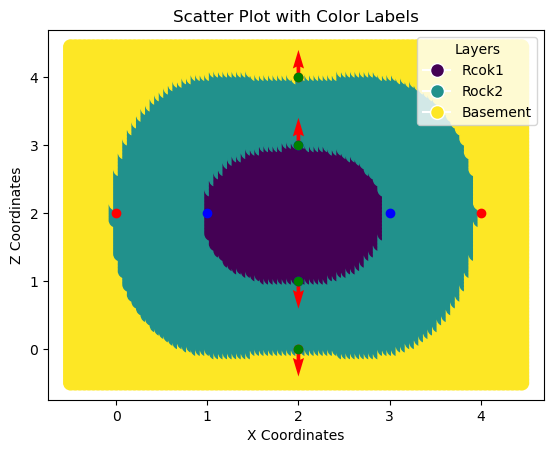

In [336]:
input_position=[torch.tensor(data= [[0,2],[2,4],[4,2],[2,0]], dtype=torch.float32),torch.tensor(data=[[1,2],[2,3],[3,2],[2,1]],dtype=torch.float32)]

gradient_position = torch.tensor([[2., 4.], [2,0], [2,3],[2,1]],dtype=torch.float32)

gradient_value = torch.tensor([[0, 1.0], [0.,-1.0], [0, 1.0], [0.,-1.0]], dtype=torch.float32)

theta = torch.tensor((torch.pi/180.0) * (0.0))

rotation = torch.reshape(torch.stack([torch.cos(theta),-torch.sin(theta),torch.sin(theta),torch.cos(theta)]), (2,2))

scale = torch.tensor([[1,0],[0,0.4]], dtype=torch.float32)


Transformation_matrix = scale @ rotation
#print("Transformation_matrix\n", Transformation_matrix)
#gradient_value = gradient_value @ Transformation_matrix
nugget_effect_grad = 0.001
nugget_effect_interface=0.001

intp = Ge_model(input_position=input_position, gradient_postion=gradient_position,gradient_value=gradient_value,nugget_effect_grad=nugget_effect_grad,nugget_effect_interface=nugget_effect_interface,Transformation_matrix=Transformation_matrix,
                plot_fig=True, plot_input_data=True, plot_scalar_field=False)

In [12]:
def model(theta_degree=30.0,scale_x=1.0, scale_y=1.0, plot_fig=True, plot_input_data=False, plot_scalar_field=False):
    
    input_position=[torch.tensor(data= [[0,2],[2,4],[4,2],[2,0]], dtype=torch.float32),torch.tensor(data=[[1,2],[2,3],[3,2],[2,1]],dtype=torch.float32)]

    gradient_position = torch.tensor([[2., 4.], [2,0], [2,3],[2,1]],dtype=torch.float32)

    gradient_value = torch.tensor([[0, 1.0], [0.,-1.0], [0, 1.0], [0.,-1.0]], dtype=torch.float32)

    theta = torch.tensor((torch.pi/180.0) * (theta_degree))

    rotation = torch.reshape(torch.stack([torch.cos(theta),-torch.sin(theta),torch.sin(theta),torch.cos(theta)]), (2,2))

    scale = torch.tensor([[scale_x,0],[0,scale_y]], dtype=torch.float32)

    Transformation_matrix = scale @ rotation

    nugget_effect_grad = 0.001
    nugget_effect_interface=0.001

    intp = Ge_model(input_position=input_position, gradient_postion=gradient_position,gradient_value=gradient_value,nugget_effect_grad=nugget_effect_grad,nugget_effect_interface=nugget_effect_interface,Transformation_matrix=Transformation_matrix,
                    plot_fig=True, plot_input_data=True, plot_scalar_field=False)
    return intp.reshape(-1)

I am in
I am in


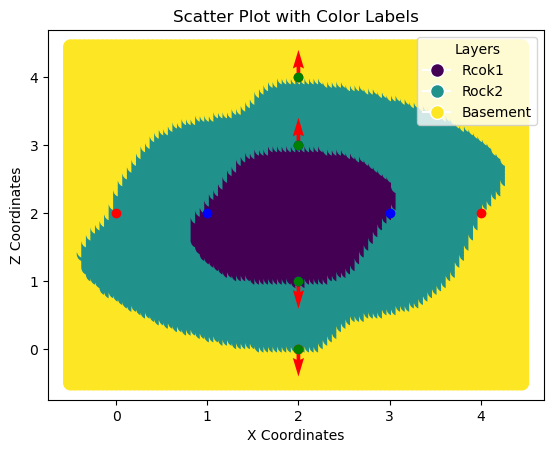

In [13]:
scalar_field = model(theta_degree=-60,scale_x=1.0,scale_y=0.3)

In [14]:
reshaped_scalar_field = scalar_field
range_data = torch.max(reshaped_scalar_field) -torch.min(reshaped_scalar_field)
seed =42
torch.manual_seed(seed)
shape_scalar_field = reshaped_scalar_field.shape
y_obs = reshaped_scalar_field + 0.05* range_data *torch.normal(size=shape_scalar_field,mean= 0.0,std=1.0, dtype=torch.float32)

In [15]:
def model_pyro(y_obs):
    theta = pyro.sample("theta", dist.Normal(0., 10.))
    #sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    sigma =10
    mean = model(theta_degree=theta, scale_x=1.0, scale_y=0.3)
    with pyro.plate("data", len(y_obs)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=y_obs)



Warmup:   0%|          | 0/2 [00:00, ?it/s]

/var/folders/lr/h2867zhs72gcy61j6_cy0n0r0000gq/T/ipykernel_68006/2236898585.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor((torch.pi/180.0) * (theta_degree))


I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in


Warmup:  50%|█████     | 1/2 [00:00,  2.45it/s, step size=2.00e+00, acc. prob=0.810]

I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in


Sample: 100%|██████████| 2/2 [00:00,  3.60it/s, step size=2.00e+00, acc. prob=0.539]


I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in
I am in


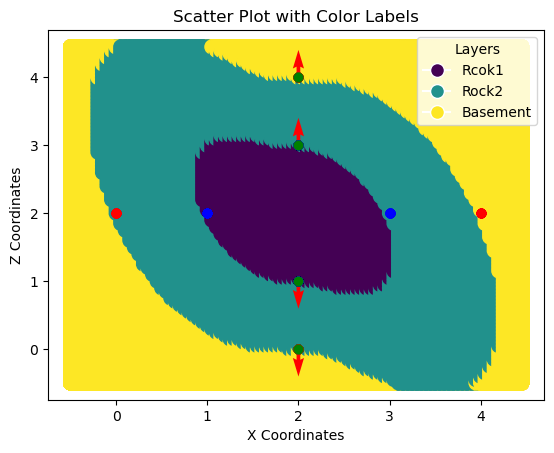

In [16]:
from pyro.infer import MCMC, NUTS


nuts_kernel = NUTS(model_pyro)

mcmc = MCMC(nuts_kernel, num_samples=1, warmup_steps=1)
mcmc.run(y_obs)

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

In [17]:
import torch
A = torch.linspace(-4,10,102)
B = 3*A + 4
B.shape
ref = torch.tensor([B[30], B[50]])
A_mod = torch.cat((A[:30], A[31:50], A[51:]))
A_min = A[A<ref[0]].min()

A_min

tensor(-4.)